In [1]:
# 适配Kaggle.json文件的路径
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 导入数据集

In [2]:
# 使用Kaggle数据集API下载数据集
!kaggle datasets download omkargurav/face-mask-dataset

Dataset URL: https://www.kaggle.com/datasets/omkargurav/face-mask-dataset
License(s): unknown
face-mask-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
# 解压数据集
from zipfile import ZipFile
dataset = '/content/face-mask-dataset.zip'
with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('数据集解压完成')

数据集解压完成


In [4]:
!ls

data  face-mask-dataset.zip  kaggle.json  sample_data


# 导入库

In [72]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms, models, utils
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import warnings
from google.colab.patches import cv2_imshow
from PIL import Image
from sklearn.model_selection import train_test_split

# 数据查看

In [73]:
with_mask_files = os.listdir('/content/data/with_mask')
print(with_mask_files[0:5])
print(with_mask_files[-5:])

['with_mask_1209.jpg', 'with_mask_2099.jpg', 'with_mask_1539.jpg', 'with_mask_1105.jpg', 'with_mask_2282.jpg']
['with_mask_3467.jpg', 'with_mask_1132.jpg', 'with_mask_495.jpg', 'with_mask_108.jpg', 'with_mask_1954.jpg']


In [74]:
without_mask_files = os.listdir('/content/data/without_mask')
print(without_mask_files[0:5])
print(without_mask_files[-5:])

['without_mask_3045.jpg', 'without_mask_2225.jpg', 'without_mask_3274.jpg', 'without_mask_3581.jpg', 'without_mask_2577.jpg']
['without_mask_1551.jpg', 'without_mask_244.jpg', 'without_mask_1804.jpg', 'without_mask_2241.jpg', 'without_mask_2685.jpg']


In [75]:
print('戴口罩的图片数：', len(with_mask_files))
print('未戴口罩的图片数：', len(without_mask_files))

戴口罩的图片数： 3725
未戴口罩的图片数： 3828


# 为两类图片设置标签

*   戴口罩 -> 1
*   未戴口罩 -> 0

In [76]:
# 创建标签

with_mask_files = [1] * 3725
without_mask_files = [0] * 3828

In [77]:
print(with_mask_files[0:5])
print(without_mask_files[0:5])

[1, 1, 1, 1, 1]
[0, 0, 0, 0, 0]


In [78]:
print(len(with_mask_files))
print(len(without_mask_files))

3725
3828


In [79]:
# 将前面创建的两个标签列表合并成一个标签列表
labels = with_mask_files + without_mask_files

print(len(labels))
print(labels[0:5])
print(labels[-5:])

7553
[1, 1, 1, 1, 1]
[0, 0, 0, 0, 0]


# 显示图像

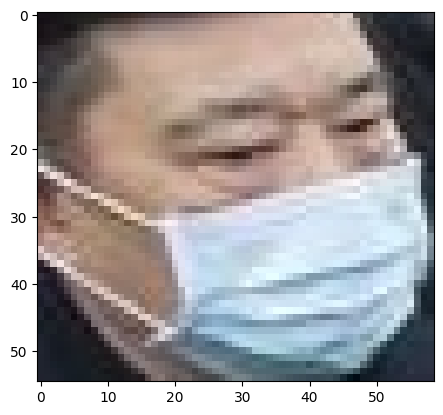

In [80]:
# 显示戴口罩的图像
img = mpimg.imread('/content/data/with_mask/with_mask_1145.jpg')
imgplot = plt.imshow(img)
plt.show()

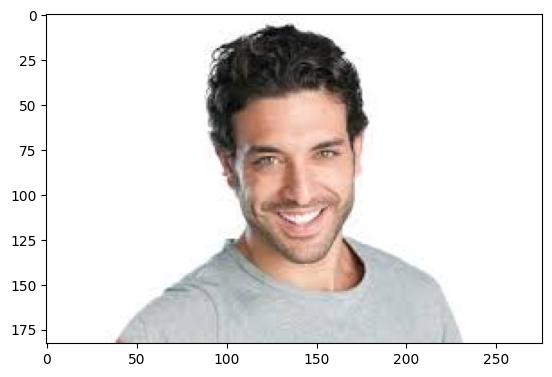

In [81]:
#显示不戴口罩的图像
img = mpimg.imread('/content/data/without_mask/without_mask_1000.jpg')
imgplot = plt.imshow(img)
plt.show()

# 图像处理


1.   调整图像大小
2.   将图像转换为numpy数组


In [82]:
#将图像转换为numpy数组
warnings.filterwarnings("ignore")

with_mask_path = '/content/data/with_mask/'
without_mask_path = '/content/data/without_mask/'
data = []

# 获取目录中所有文件的列表
with_mask_files = os.listdir(with_mask_path)
without_mask_files = os.listdir(without_mask_path)

for img_file in with_mask_files:
  # 构造完整的文件路径
  image_path = os.path.join(with_mask_path, img_file)

  # 使用完整路径打开图像
  image = Image.open(image_path)
  image = image.resize((128,128))
  image = image.convert('RGB')
  image = np.array(image)
  data.append(image)

# 未戴口罩的图像数据同样适用以上方法
for img_file in without_mask_files:
  image_path = os.path.join(without_mask_path, img_file)
  image = Image.open(image_path)
  image = image.resize((128,128))
  image = image.convert('RGB')
  image = np.array(image)
  data.append(image)

In [83]:
# 查看数据类型
type(data)

list

In [84]:
# 查看列表长度
len(data)

7553

array([[[ 42,  49,  41],
        [ 44,  51,  43],
        [ 51,  58,  50],
        ...,
        [ 50,  36,  40],
        [ 52,  37,  40],
        [ 53,  37,  40]],

       [[ 42,  49,  41],
        [ 44,  51,  43],
        [ 50,  57,  49],
        ...,
        [ 47,  33,  37],
        [ 49,  34,  37],
        [ 49,  34,  37]],

       [[ 42,  49,  41],
        [ 43,  50,  42],
        [ 47,  54,  47],
        ...,
        [ 40,  28,  33],
        [ 41,  28,  32],
        [ 41,  28,  32]],

       ...,

       [[253, 250, 246],
        [254, 250, 245],
        [255, 249, 244],
        ...,
        [218, 193,  87],
        [218, 193,  87],
        [218, 193,  87]],

       [[249, 245, 242],
        [250, 246, 243],
        [252, 249, 245],
        ...,
        [219, 194,  89],
        [220, 194,  89],
        [220, 194,  89]],

       [[247, 243, 241],
        [248, 245, 242],
        [251, 249, 245],
        ...,
        [220, 194,  89],
        [221, 194,  89],
        [221, 194,  89]]], dtype=uint8)
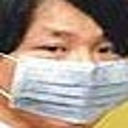

In [85]:
data[0]

In [86]:
type(data[0])

numpy.ndarray

In [87]:
data[0].shape

(128, 128, 3)

In [88]:
# 将图像列表和标签列表转换为numpy数组

X = np.array(data)
y = np.array(labels)

In [89]:
type(X)
type(y)

numpy.ndarray

In [90]:
print(X.shape)
print(y.shape)

(7553, 128, 128, 3)
(7553,)


In [91]:
print(y)

[1 1 1 ... 0 0 0]


# 切分训练集与测试集

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [93]:
print(X.shape, X_train.shape, X_test.shape)

(7553, 128, 128, 3) (6042, 128, 128, 3) (1511, 128, 128, 3)


In [94]:
# 数据标准化
X_train_scaled = X_train/255
X_test_scaled = X_test/255

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[229, 233, 234],
        [221, 225, 226],
        [212, 216, 217],
        ...,
        [247, 247, 247],
        [246, 246, 246],
        [246, 246, 246]],

       [[228, 232, 233],
        [220, 224, 225],
        [211, 215, 216],
        ...,
        [246, 246, 246],
        [245, 245, 245],
        [245, 245, 245]],

       [[227, 231, 232],
        [219, 223, 224],
        [210, 214, 215],
        ...,
        [245, 245, 245],
        [244, 244, 244],
        [244, 244, 244]]], dtype=uint8)
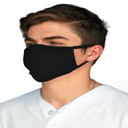

In [95]:
X_train[0]

In [96]:
X_train_scaled[0]

array([[[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       ...,

       [[0.89803922, 0.91372549, 0.91764706],
        [0.86666667, 0.88235294, 0.88627451],
        [0.83137255, 0

# 构建CNN模型

In [97]:
class MaskDetectionCNN(nn.Module):
    def __init__(self):
        super(MaskDetectionCNN, self).__init__()

        # 定义卷积层
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # 输入通道=3，输出通道=32，卷积核=3x3
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # 输入通道=32，输出通道=64
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # 输入通道=64，输出通道=128

        # 定义池化层
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 2x2最大池化

        # 定义全连接层
        self.fc1 = nn.Linear(128 * 16 * 16, 256)  # 输入大小=卷积输出展平后的大小，输出大小=256
        self.fc2 = nn.Linear(256, 1)  # 输出大小=1（二分类）

        # 定义激活函数
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()  # 用于二分类输出

    def forward(self, x):
        # 前向传播
        x = self.pool(self.relu(self.conv1(x)))  # 第一层卷积+激活+池化
        x = self.pool(self.relu(self.conv2(x)))  # 第二层卷积+激活+池化
        x = self.pool(self.relu(self.conv3(x)))  # 第三层卷积+激活+池化

        x = x.view(-1, 128 * 16 * 16)  # 展平（Flatten）
        x = self.relu(self.fc1(x))  # 第一全连接层+激活
        x = self.sigmoid(self.fc2(x))  # 第二全连接层+Sigmoid

        return x


# 设置数据加载器

In [116]:
# 将numpy数组转换为PyTorch张量
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).permute(0, 3, 1, 2)  # 转换为(C, H, W)格式
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).permute(0, 3, 1, 2)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # 标签为一维
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# 创建训练和验证数据集
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 定义训练过程

In [129]:
# 检测设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 实例化模型
model = MaskDetectionCNN().to(device)

# 定义损失函数和优化器
criterion = nn.BCELoss()  # 二分类交叉熵损失
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs):
    train_loss_values = []
    val_loss_values = []
    train_acc_values = []
    val_acc_values = []

    for epoch in range(epochs):
        # 训练阶段
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()  # 梯度清零
            outputs = model(inputs)
            loss = criterion(outputs, targets)  # 计算损失
            loss.backward()  # 反向传播
            optimizer.step()  # 更新参数

            train_loss += loss.item()

            # 计算训练准确性
            predictions = (outputs > 0.5).float()
            correct_train += (predictions == targets).sum().item()
            total_train += targets.size(0)

        train_loss_values.append(train_loss / len(train_loader))
        train_acc_values.append(correct_train / total_train)

        # 验证阶段
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

                # 计算验证准确性
                predictions = (outputs > 0.5).float()
                correct_val += (predictions == targets).sum().item()
                total_val += targets.size(0)

        val_loss_values.append(val_loss / len(val_loader))
        val_acc_values.append(correct_val / total_val)

        # 打印当前epoch的损失和准确性
        print(f'Epoch [{epoch+1}/{epochs}], '
              f'Train Loss: {train_loss / len(train_loader):.4f}, Train Acc: {correct_train / total_train:.4f}, '
              f'Val Loss: {val_loss / len(val_loader):.4f}, Val Acc: {correct_val / total_val:.4f}')

          # 绘制训练过程中的损失和准确性变化
    plt.figure(figsize=(12, 5))

    # 绘制损失值曲线
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_loss_values, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_loss_values, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epochs')
    plt.legend()

    # 绘制准确性曲线
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_acc_values, label='Train Accuracy')
    plt.plot(range(1, epochs + 1), val_acc_values, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()


# 训练

Epoch [1/10], Train Loss: 0.3801, Train Acc: 0.8275, Val Loss: 0.2775, Val Acc: 0.8795
Epoch [2/10], Train Loss: 0.2417, Train Acc: 0.9009, Val Loss: 0.2262, Val Acc: 0.9073
Epoch [3/10], Train Loss: 0.2079, Train Acc: 0.9189, Val Loss: 0.1929, Val Acc: 0.9159
Epoch [4/10], Train Loss: 0.1641, Train Acc: 0.9355, Val Loss: 0.1785, Val Acc: 0.9272
Epoch [5/10], Train Loss: 0.1402, Train Acc: 0.9469, Val Loss: 0.1558, Val Acc: 0.9351
Epoch [6/10], Train Loss: 0.1090, Train Acc: 0.9593, Val Loss: 0.1686, Val Acc: 0.9345
Epoch [7/10], Train Loss: 0.0933, Train Acc: 0.9651, Val Loss: 0.1729, Val Acc: 0.9378
Epoch [8/10], Train Loss: 0.0676, Train Acc: 0.9758, Val Loss: 0.1929, Val Acc: 0.9285
Epoch [9/10], Train Loss: 0.0467, Train Acc: 0.9848, Val Loss: 0.1642, Val Acc: 0.9437
Epoch [10/10], Train Loss: 0.0389, Train Acc: 0.9848, Val Loss: 0.1645, Val Acc: 0.9464


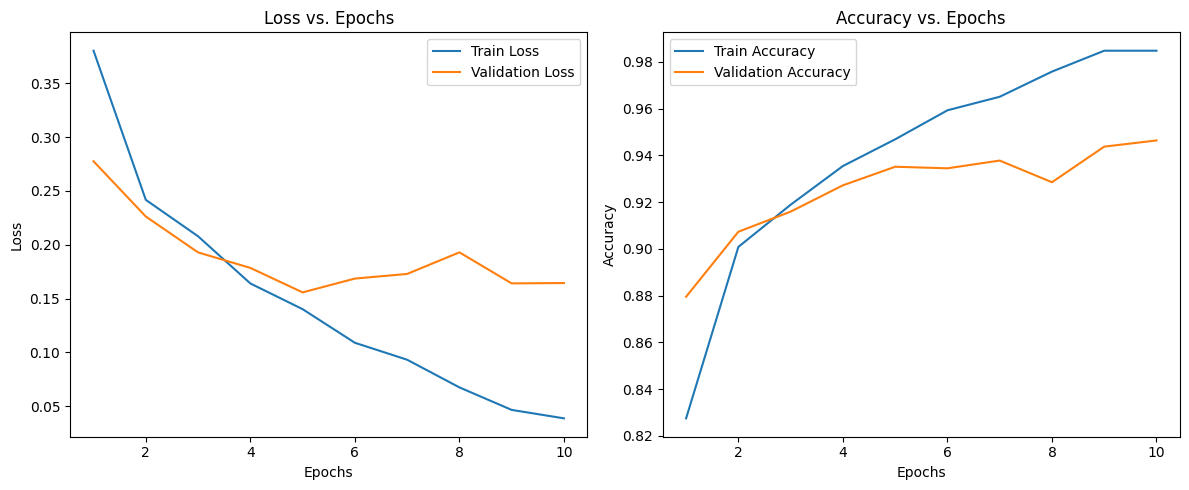

In [130]:
# 训练模型
train_model(model, criterion, optimizer, train_loader, test_loader, epochs=10)

# 保存模型

In [131]:
PATH = "FaceMask.pt"

torch.save(model, PATH)

# 验证模型性能

In [132]:
# 测试阶段评估准确率
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()  # 阈值为0.5，二分类
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
    accuracy = correct / total
    print(f'准确率: {accuracy * 100:.2f}%')

# 评估模型
evaluate_model(model, test_loader)

准确率: 94.64%


# 模型预测

请输入用以预测的图片的路径：/content/data/with_mask/with_mask_1894.jpg


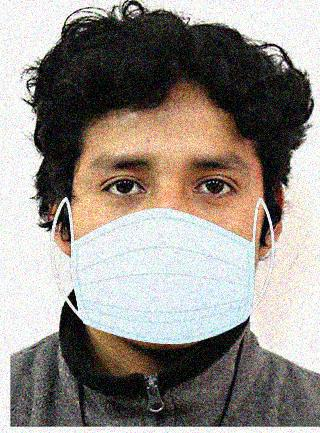

图片中的人戴口罩


In [134]:
def predictive_system(image_path, model):
    # 读取输入图像
    input_image = cv2.imread(image_path)

    # 显示图像
    cv2_imshow(input_image)

    # 图像预处理
    input_image_resized = cv2.resize(input_image, (128, 128))  # 调整图像大小
    input_image_scaled = input_image_resized / 255.0  # 标准化
    input_image_reshaped = np.reshape(input_image_scaled, (1, 3, 128, 128))  # 调整形状
    input_image_tensor = torch.tensor(input_image_reshaped, dtype=torch.float32).to(device)

    # 进行预测
    model.eval()
    with torch.no_grad():
        input_prediction = model(input_image_tensor)
        input_pred_label = (input_prediction > 0.5).float().item()

    # 显示预测结果
    if input_pred_label == 1:
        print("图片中的人没有口罩")
    else:
        print("图片中的人戴口罩")

# 输入待预测的图像路径
image_path = input("请输入用以预测的图片的路径：")
predictive_system(image_path, model)

请输入用以预测的图片的路径：/content/data/without_mask/without_mask_1002.jpg


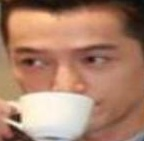

图片中的人没有口罩


In [135]:
def predictive_system(image_path, model):
    # 读取输入图像
    input_image = cv2.imread(image_path)

    # 显示图像
    cv2_imshow(input_image)

    # 图像预处理
    input_image_resized = cv2.resize(input_image, (128, 128))  # 调整图像大小
    input_image_scaled = input_image_resized / 255.0  # 标准化
    input_image_reshaped = np.reshape(input_image_scaled, (1, 3, 128, 128))  # 调整形状
    input_image_tensor = torch.tensor(input_image_reshaped, dtype=torch.float32).to(device)

    # 进行预测
    model.eval()
    with torch.no_grad():
        input_prediction = model(input_image_tensor)
        input_pred_label = (input_prediction > 0.5).float().item()

    # 显示预测结果
    if input_pred_label == 1:
        print("图片中的人没有口罩")
    else:
        print("图片中的人戴口罩")

# 输入待预测的图像路径
image_path = input("请输入用以预测的图片的路径：")
predictive_system(image_path, model)